# Boulder Residential Property Valuation Appraiser


> Objectives
>
> - Implement a new version of the House Appraiser model with support for multiple features using XGBoost.
> - Use SciKit-Learn's Pipeline functionality for data preprocessing and model evaluation.
> - Perform Cross-Validation, a technique for gauging model generalizability and comparing model.
> - Use Hyperparameter Tuning to optimize training


## Runtime Environment Set Up


In [ ]:
import sys, os
sys.path.insert(0, os.path.join('..', 'includes'))

import setup
setup.initialize_environment()
if setup.environment == 'VIRTUAL':
    %pip install -q python-dotenv==1.0.0 pandas==2.2.1 matplotlib==3.8.3 scikit-learn==1.4.1.post1 openpyxl seaborn geopy

🎉 Running in a Virtual environment
ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for mpl_toolkits
Note: you may need to restart the kernel to use updated packages.


---


# Context

Given the methods described by [Boulder County Tax Assessor > Real Property Assessment & Valuation](https://bouldercounty.gov/property-and-land/assessor/assessment/), the Boulder County Assessor uses 24 months of sales data and up to 5 years prior if [not enough data](https://bouldercounty.gov/property-and-land/assessor/assessment/valuation/#:~:text=An%2018%2Dmonth%20base%20period%20is%20used%20for%20property%20assessment%20by%20statute.%20To%20take%20into%20account%20any%20seasonality%20of%20sales%2C%20the%20Boulder%20County%20Assessor%20uses%2024%20months%20of%20sales%20data.%20If%20there%20are%20not%20enough%20sales%20during%20that%20time%2C%20up%20to%20five%20years%20of%20data%20can%20be%20used%20for%20comparison%20purposes.) is available.

## Time Trend Analysis

The assessor's site refers to the concept of a [Time Trend Adjustment](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/time-trend/) that is used in the following fashion to generate an appraised valuation for a particular property.

![Time Trend Adjustment factoring](./assets/sales_price_estimator.png)


The county maintains a publicly accessible list of [Time Trend Factors](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/factors/) for which the time trend factors for 2023 are included in this study along with the corresponding sales data:
- [2023 Boulder Residential Time Trends](./assets/ar-trend-2023-residential-boulder-sheet.xlsx) published April 26, 2023
- [Market Area 101 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-101-sheet.xlsx)
- [Market Area 102 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-102-sheet.xlsx)
- [Market Area 103 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-103-sheet.xlsx)
- [Market Area 104 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-104-sheet.xlsx)
- [Market Area 105 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-105-sheet.xlsx)
- [Market Area 106 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-106-sheet.xlsx)
- [Market Area 107 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-107-sheet.xlsx)


## Exercise Goals:


- In this exercise we will be using Decision Tree Regression model to predict a house's price, given other features about the house.
  - This model will be able to perform multiple regression — using multiple features to perform prediction — like you did with SciKit-Learn in previous exercises.


## Imports


In [32]:
import pandas as pd  # interface for data loading
import matplotlib.pyplot as plt  # visualization
from sklearn.model_selection import train_test_split  # splitting data
from sklearn.metrics import mean_absolute_error  # evaluation metric
from sklearn.compose import ColumnTransformer  # processing columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # processing string data
from sklearn.impute import SimpleImputer  # processing missing data
from sklearn.pipeline import Pipeline  # pipeline constructor
from sklearn.model_selection import cross_val_score  # cross-validation
from sklearn.model_selection import GridSearchCV  # hyperparameter tuning
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelBinarizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import seaborn as sns
import time

## Data Utilities

Helpful loading and normalizing functions

In [13]:
import pandas as pd
import os
import numpy as np

def merge_excel_sheets(folder_path: str):
    """
    Merges multiple Excel sheets within a folder into a single pandas DataFrame.

    Args:
    folder_path: Path to the folder containing the Excel files.

    Returns:
    A pandas DataFrame containing the merged data.
    """

    # Get a list of all Excel files in the folder
    excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

    # Create an empty list to store DataFrames
    dataframes = []

    # Load each Excel file into a DataFrame and append to the list
    for file in excel_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path, dtype=str)
        dataframes.append(df)

    # Merge all DataFrames into a single DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)

    return merged_df


def clean_numerical_features(df, price_features=[], surface_area_features=[]):
    """
    Cleans numerical and date columns in a DataFrame by standardizing formats and converting types.

    Args:
    df: A pandas DataFrame.
    price_features: List of pricing columns (with $ and commas).
    surface_area_features: List of square footage properties.

    Returns:
    A pandas DataFrame with cleaned column data.
    """

    # ✅ Ensure Currency Columns Are Float
    df[price_features] = df[price_features].applymap(lambda x: str(x).replace("$", "").replace(",", ""))
    df[price_features] = df[price_features].astype(float)

    # ✅ Ensure Numerical Columns Are Float
    df[surface_area_features] = df[surface_area_features].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

    return df


def save_to_csv(df, file_path: str):
    """
    Saves a DataFrame to a CSV file.

    Args:
    df: A pandas DataFrame.
    file_path: Path to save the CSV file.
    """

    df.to_csv(file_path, index=False)


---

# Data Source - Boulder County Time Trends

In accordance with Colorado law, we are restricting use of property sales data to that which is allowed and published [here](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/factors/) for 2023 Boulder Residential Time Trends.

Leveraging the [comparable property sales data](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/residential/#Market-Area-101) as published on the public site for reference in performing the market approach of valuation analysis.

## Location matters (~40min)

Geoencode subject property addresses for proximity clustering analysis. Consolidating all the sales data and enriching it with spatial coordinates enables us to perform a more contextually relevant and robust similarity search in valuation space.

In [8]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.base import BaseEstimator, TransformerMixin
from caffeinate_manager import start_caffeinate, stop_caffeinate


class GeocodeTransformer(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer for geocoding addresses into latitude/longitude.

    Nominatim usage policy: https://operations.osmfoundation.org/policies/nominatim/

    © OpenStreetMap https://www.openstreetmap.org/copyright contributors

    Parameters:
    - street_number: Column name for the street number
    - street_dir: Column name for the street direction (E, N, W, S)
    - street_name: Column name for the street name
    - street_suffix: Column name for the street suffix (Ave, St, Rd)
    - location: Column name for the city/location
    - batch_size: Number of rows to process per batch (default: 50)
    - batch_delay: Number of seconds to wait between batches (default: 1)
    - user_agent: Unique user agent for geopy (default: "property_geocoder")
    """

    def __init__(self, street_number, street_dir, street_name, street_suffix, location, batch_size=50, batch_delay=1, user_agent="property_geocoder"):
        self.street_number = street_number
        self.street_dir = street_dir
        self.street_name = street_name
        self.street_suffix = street_suffix
        self.location = location
        self.batch_size = batch_size
        self.batch_delay = batch_delay
        self.user_agent = user_agent
        self.geolocator = Nominatim(user_agent=self.user_agent, timeout=10)

    def _get_lat_lon(self, address):
        """Fetches lat/lon with retries."""
        if pd.isna(address) or address.strip() == "":
            return pd.Series([None, None])  # Handle empty addresses

        attempt = 0
        while attempt < 3:  # Retry up to 3 times if a timeout occurs
            try:
                location = self.geolocator.geocode(address)
                if location:
                    return pd.Series([location.latitude, location.longitude])
                else:
                    return pd.Series([None, None])  # No result found
            except GeocoderTimedOut:
                attempt += 1
                time.sleep(2)  # Wait before retrying

        return pd.Series([None, None])  # Return None if all attempts fail

    def _batch_geocode(self, df, address_column):
        """Processes geocoding in batches to avoid rate limiting."""
        df[['lat', 'lon']] = None

        for i in range(0, len(df), self.batch_size):
            batch = df.iloc[i:i + self.batch_size].copy()

            print(f'Geocoding batch {i + 1}-{i + len(batch)}...')
            batch[['lat', 'lon']] = batch[address_column].apply(self._get_lat_lon)

            df.iloc[i:i + self.batch_size, df.columns.get_loc('lat')] = batch['lat']
            df.iloc[i:i + self.batch_size, df.columns.get_loc('lon')] = batch['lon']

            time.sleep(self.batch_delay)  # Pause to avoid rate limiting

        return df

    def fit(self, X, y=None):
        """No fitting required, returns self."""
        return self

    def transform(self, X):
        """Adds latitude/longitude columns to the DataFrame."""
        X = X.copy()  # Avoid modifying original dataset

        # Construct full address column
        X['full_address'] = (
            X[self.street_number].astype(str) + " " +
            X[self.street_dir].fillna('') + " " +
            X[self.street_name] + " " +
            X[self.street_suffix].fillna('') + ", " +
            X[self.location] + ", CO"
        ).str.replace(' +', ' ', regex=True).str.strip()

        # Perform batch geocoding
        X = self._batch_geocode(X, address_column='full_address')

        X.drop(columns=['full_address'], inplace=True)  # Remove temporary column
        return X # Return full enriched DataFrame


folder_path = './assets/boulder_sales_2024'
boulder_sales_2024_df = merge_excel_sheets(folder_path)
print("Boulder raw sales 2024 data shape:", boulder_sales_2024_df.shape)
print(boulder_sales_2024_df.info())
print(boulder_sales_2024_df.columns.to_list())
print(boulder_sales_2024_df.head())

geo_transformer = GeocodeTransformer(
    street_number="Property Address Street Number",
    street_dir="Property Address Street Dir",
    street_name="Property Address Street Name",
    street_suffix="Property Address Street Suffix",
    location="Location",
    batch_size=50,
    batch_delay=1,
    user_agent="boulder_property_locator"
)

start_caffeinate()  # Prevent system sleep during geocoding
# Enrich the columns of the DataFrame with lat/lon
boulder_sales_2024_df = geo_transformer.transform(boulder_sales_2024_df)
stop_caffeinate()  # Allow system sleep after geocoding

# Save the geo enriched  data to a CSV file
save_to_csv(boulder_sales_2024_df, 'assets/boulder_sales_2024__geocoded.csv')


Boulder raw sales 2024 data shape: (2492, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Accout Number                   2492 non-null   object
 1   Property Type                   2492 non-null   object
 2   Property Address Street Number  2492 non-null   object
 3   Property Address Street Dir     129 non-null    object
 4   Property Address Street Name    2491 non-null   object
 5   Property Address Street Suffix  2484 non-null   object
 6   Property Address Unit Number    19 non-null     object
 7   Location                        2491 non-null   object
 8   Design                          2492 non-null   object
 9   Quality                         2492 non-null   object
 10  Eff Yr Built                    2492 non-null   object
 11  Above Grd SF                    2492 non-null   object
 12  Ba

## Feature engineering

Enriching the source data with location attributes allows for more precise and accurate property valuation given regional variance.

Let's begin by loading the data

- [x] Explore the data in `boulder_sales_2024__geocoded.csv` and note the available features.
- [x] Pre-process the columns to be properly vectorized for exploration and distribution characterization
- [x] Split the dataset into subsets using SciKit-Learn's `train_test_split`


In [79]:
# Plan of action (from team feedback)

# PART I - PROTEST
# 1. Talk with ML expert contracted by the county - "what are the assumptions?"
# 2. Protest "if you can provide analysis that shows the model is wrong"
# 2b. break windows
# 2c. show leaky roofs
# 2d. can you show characteristics that would sell for the blue number? split-screen "my house" vs "Tony Starks house"

# PART II - ETHICAL ML MODEL
# Define fairness?? What does that mean? I'm a homeowner, i will make all the coefficients negative
# - metrics of success (other counties not doing so hot! prove we can have negative coefficients and the generalizability of the model)

# ML Trend Forecast Expert Questions:
# - resolution of predictions?
# - periodic retraining?
# - hyperparameters?
# - what is the model? (should be open sourced for transparency to tax payers, not require reverse engineering)
# - dataset size too limited? small, sparse, not enough data, why not stick to heuristics or historically accurate CMA?
# - what is the model's confidence interval?
# - what is the model's accuracy?
# - what is the model's precision?
# - what is the model's recall?
# - what is the model's F1 score?
# - what is the model's ROC-AUC?
# - what is the model's PR-AUC?
# - what is the model's calibration curve?
# - what is the model's confusion matrix?
# - what is the model's feature importance?


# Define transforms
# "Time Trends" magic numbers

# 1. Load and enrich the dataset
boulder_sales_2024_df = pd.read_csv("assets/boulder_sales_2024__geocoded.csv")
print("Boulder sales 2024 data shape:", boulder_sales_2024_df.shape)
print(boulder_sales_2024_df.info())
print(boulder_sales_2024_df.describe())
print(boulder_sales_2024_df.head())


Boulder sales 2024 data shape: (2492, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Accout Number                   2492 non-null   object 
 1   Property Type                   2492 non-null   object 
 2   Property Address Street Number  2492 non-null   int64  
 3   Property Address Street Dir     129 non-null    object 
 4   Property Address Street Name    2491 non-null   object 
 5   Property Address Street Suffix  2484 non-null   object 
 6   Property Address Unit Number    19 non-null     object 
 7   Location                        2491 non-null   object 
 8   Design                          2492 non-null   object 
 9   Quality                         2492 non-null   object 
 10  Eff Yr Built                    2492 non-null   int64  
 11  Above Grd SF                    2492 non-null   objec

### Feature pruning

In [80]:
remove_columns = [
    "Accout Number",
    "Reception No",
    "Property Address Street Suffix",
    "Property Address Unit Number",
    "Property Address Street Name",
    "Property Address Street Number",
    "Location",
]
print(f'Removing columns: {remove_columns}')
boulder_sales_2024_df = boulder_sales_2024_df.drop(columns=remove_columns, errors="ignore")

# Display the unique values in each column
for column_name in boulder_sales_2024_df.columns:
    print(boulder_sales_2024_df[column_name].value_counts().sort_index())

Removing columns: ['Accout Number', 'Reception No', 'Property Address Street Suffix', 'Property Address Unit Number', 'Property Address Street Name', 'Property Address Street Number', 'Location']
Property Type
Dup/Tri      82
Res        2410
Name: count, dtype: int64
Property Address Street Dir
E    21
N     6
S    96
W     6
Name: count, dtype: int64
Design
2-3 Story      1209
Bi-Level        115
Ranch           904
Split-Level     264
Name: count, dtype: int64
Quality
Average      1200
Excellent      79
Fair            1
Good          852
Very Good     360
Name: count, dtype: int64
Eff Yr Built
1905     1
1920     1
1930     1
1940     1
1947     1
        ..
2018    20
2019    12
2020     5
2021     3
2022     1
Name: count, Length: 77, dtype: int64
Above Grd SF
1,000     1
1,003     1
1,006     2
1,008    13
1,014     3
         ..
980       1
986       2
988       4
990       2
999       1
Name: count, Length: 1401, dtype: int64
Basemt Tot SF
0        874
1,000      4
1,001      2

### Price features

In [81]:
# Apply log transformation for skewed values
price_features = ["Sale Price", "Time Adjust Sales Price"]
surface_area_features = [
    "Garage SF",
    "Above Grd SF",
    "Basemt Tot SF",
    "Basemt Fin SF",
    "Basemt Unf SF",
    "Est Land SF",
]
# Function to apply log transformation for skewed values
numerical_log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

boulder_sales_2024_df = clean_numerical_features(
    boulder_sales_2024_df,
    price_features=price_features,
    surface_area_features=surface_area_features
)

/var/folders/zx/qs5pg9y93w36q1r9vt3dwv6h0000gn/T/ipykernel_10910/2402629055.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[price_features] = df[price_features].applymap(lambda x: str(x).replace("$", "").replace(",", ""))


### Time features

In [94]:
# Function to extract all date-based features
time_features = ["Sale Date (Mon-Yr)"]
def extract_time_features(X):
    X = pd.to_datetime(X.iloc[:, 0])  # Ensure it's a datetime column
    return pd.DataFrame({
        "sale_year": X.dt.year,
        "sale_month": X.dt.month,
        "sale_day": X.dt.day,
        "sale_weekday": X.dt.weekday,  # 0 = Monday, 6 = Sunday
        "sale_quarter": X.dt.quarter,
        "sale_days_since_epoch": (X - pd.Timestamp("1970-01-01")) // pd.Timedelta(days=1),
        "sale_month_sin": np.sin(2 * np.pi * X.dt.month / 12),
        "sale_month_cos": np.cos(2 * np.pi * X.dt.month / 12),
        "sale_weekday_sin": np.sin(2 * np.pi * X.dt.weekday / 7),
        "sale_weekday_cos": np.cos(2 * np.pi * X.dt.weekday / 7)
    })

# Transformer for time features
time_transformer = FunctionTransformer(
    func=extract_time_features,
    feature_names_out=lambda _, input_features: [
        "sale_year", "sale_month", "sale_day", "sale_weekday", "sale_quarter",
        "sale_days_since_epoch", "sale_month_sin", "sale_month_cos",
        "sale_weekday_sin", "sale_weekday_cos"
    ])

# Min-Max scaling for year
year_features = ["Eff Yr Built"]
year_transformer = MinMaxScaler()

### Location features

In [95]:
# Standard scaling for latitude/longitude
geo_features = ["lat", "lon"]
geo_transformer = StandardScaler()

# Custom transformer for cardinal directions (Trigonometric Encoding)
direction_features = ["Property Address Street Dir"]
def direction_transform(X):
    direction_map = { "N": 0, "E": 90, "S": 180, "W": 270 }

    # Ensure X is a NumPy array of strings to avoid NoneType issues
    X = np.array(X, dtype=str)

    # Replace any "nan" strings or None with "N" (default direction)
    X = np.where((X == "nan") | (pd.isna(X)) | (X == None), "N", X)

    # Convert mapped values to angles
    X = np.vectorize(direction_map.get)(X)

    # Compute sin and cos transformations
    sin_X = np.sin(np.radians(X))
    cos_X = np.cos(np.radians(X))

    # Return transformed features
    return np.c_[sin_X, cos_X]
direction_transformer = FunctionTransformer(
    direction_transform,
    feature_names_out=lambda _, input_features: ["direction_sin", "direction_cos"]
)

### Categorical features

In [84]:
binary_features = [
    "Distress Sale",
    "Property Type",
]
binary_transformer = OneHotEncoder(drop="if_binary", sparse_output=False)  # Handles two unique values as binary encoding

categorical_features = [
    "Design",
    "Garage Type",
]
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Convert ordinal category with values
quality_features = ["Quality"]
quality_order = ['Excellent', 'Very Good', 'Good', 'Average', 'Fair']
quality_transformer = OrdinalEncoder(categories=[list(reversed(quality_order))])

### Preprocessing Pipeline

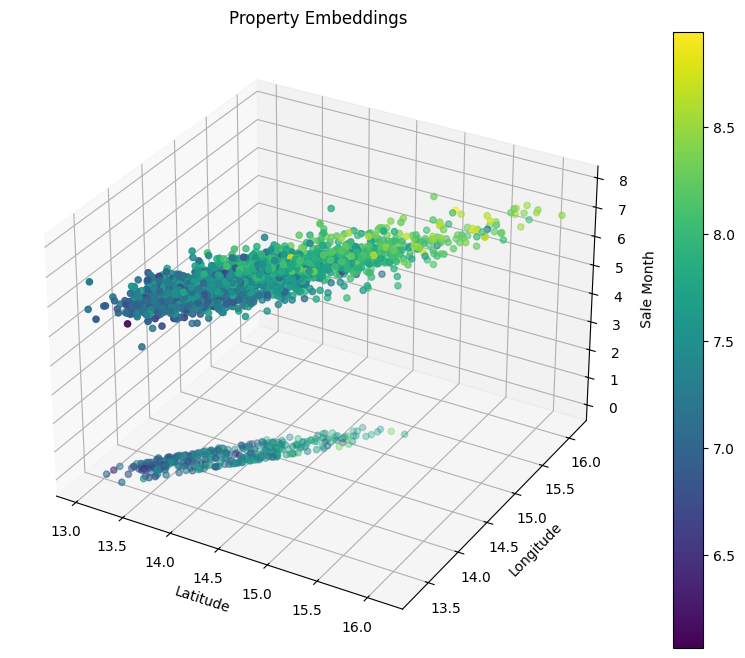

In [128]:
preprocessor = ColumnTransformer(
    transformers = [
        ("numerical_log_transform", numerical_log_transformer, price_features + surface_area_features),
        ("std_scale", geo_transformer, geo_features),
        ("minmax_scale", year_transformer, year_features),
        ('time_encoder', time_transformer, time_features),
        ('categorical_encoder', categorical_transformer, categorical_features),
        ('binarizer', binary_transformer, binary_features),
        ('direction_encoder', direction_transformer, direction_features),
        ('quality_encoder', quality_transformer, quality_features),
    ],
    remainder="passthrough"
)

# Apply the preprocessor to the dataset
X = preprocessor.fit_transform(boulder_sales_2024_df)

# plot 3-D scatter plot of lat, lng, and sale month, use color to represent sale price using plt
# make the plot interactive
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# use actual sales price in legend
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 3], cmap='viridis')
plt.colorbar(scatter)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Sale Month')
plt.title("Property Embeddings")
plt.show()


## Model training

The regression model of choice is a decision tree for its explainability and maintenance — a function that produces a probable output based on a particular feature.

### Data splitting

Boulder Sales Data =>
   numerical_log_transform__Sale Price  \
0                            13.560620   
1                            13.253393   
2                            13.262127   
3                            13.507627   
4                            13.446620   

   numerical_log_transform__Time Adjust Sales Price  \
0                                         13.560620   
1                                         13.567563   
2                                         13.632790   
3                                         13.650755   
4                                         13.637461   

   numerical_log_transform__Garage SF  numerical_log_transform__Above Grd SF  \
0                            5.484797                               6.675823   
1                            5.659482                               6.805723   
2                            5.398163                               6.685861   
3                            0.000000                               6.8987

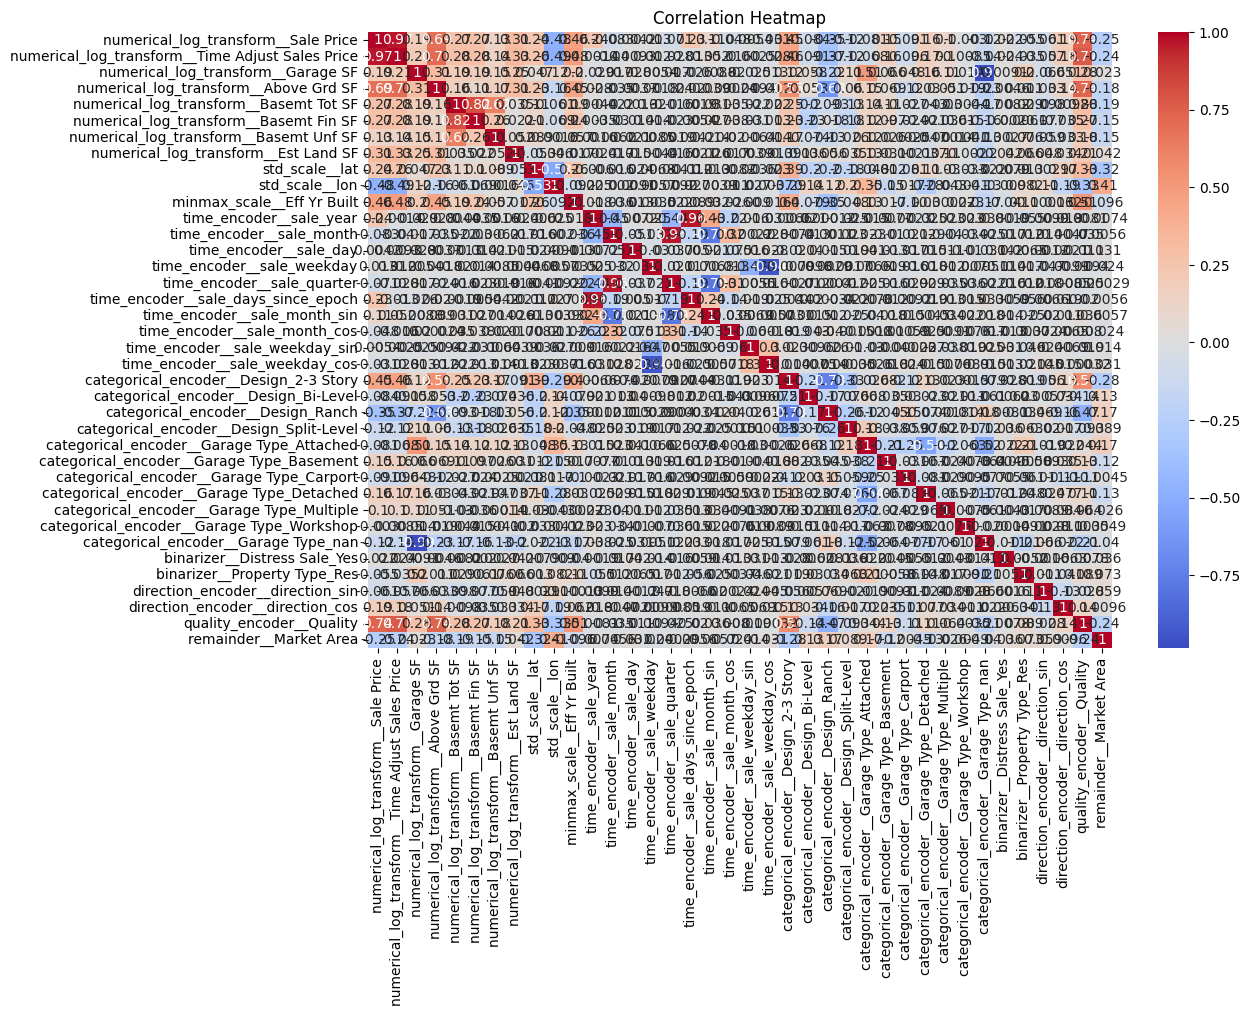

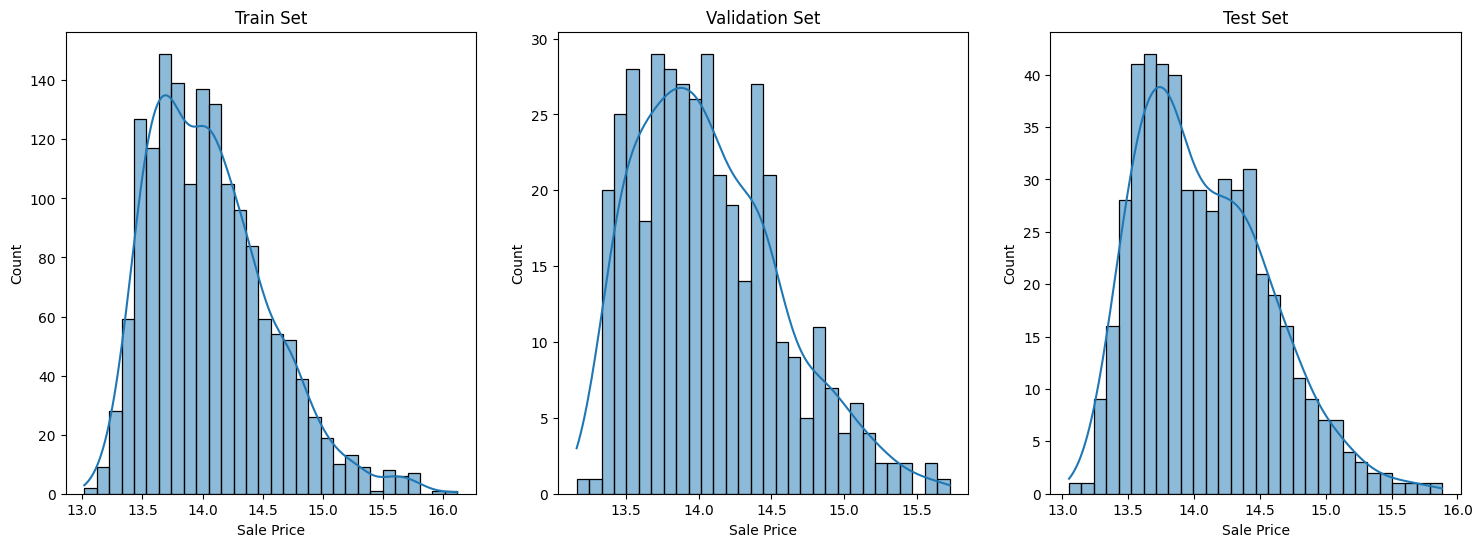


      Skew Assessment:
      Interpretation:
	•	|Skew| < 1.0 → Slight skew, usually fine
	•	|Skew| > 1.0 → Moderate skew, consider transforming
	•	|Skew| > 2.0 → Highly skewed, transformation recommended
      
0.8083035430710761 0.6786603612918638


In [129]:
X_df = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
# Normalize the target variable (log transform to offset skew from outliers)
y = np.log1p(boulder_sales_2024_df["Sale Price"])

print("Boulder Sales Data =>")
print(X_df.head())
print()

# Correlation heatmap (post ordinal encoding of ocean_proximity)
plt.figure(figsize=(12, 8))
correlation_matrix = X_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# plot samples of x train and x val and x test to inspect stratification and well-balance of classes
# plot histograms of the target variable in the train, val, and test sets
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(y_train, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Train Set')
sns.histplot(y_val, bins=30, kde=True, ax=axes[1])
axes[1].set_title('Validation Set')
sns.histplot(y_test, bins=30, kde=True, ax=axes[2])
axes[2].set_title('Test Set')
plt.show()

print("""
      Skew Assessment:
      Interpretation:
	•	|Skew| < 1.0 → Slight skew, usually fine
	•	|Skew| > 1.0 → Moderate skew, consider transforming
	•	|Skew| > 2.0 → Highly skewed, transformation recommended
      """)
print(y_train.skew(), y_test.skew())

### Train

In [ ]:
# print("Available columns in DataFrame:")
# print(boulder_sales_2024_df.columns.tolist())  # Ensure "Sale Price" is present

# # Ensure X_train is transformed using the same preprocessor
# preprocessor.fit(X_train)

# X_train_transformed = preprocessor.transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)

# # Convert to DataFrame
# X_train_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
# X_test_df = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())

# # Ensure the target variable is still properly formatted
# y_train = np.log1p(y_train)  # Apply log transformation if necessary
# y_test = np.log1p(y_test)

# # Debug: Check if columns match
# print("X_train columns:", X_train_df.columns.tolist())
# print("Preprocessor feature names:", preprocessor.get_feature_names_out())

Available columns in DataFrame:
['Property Type', 'Property Address Street Dir', 'Design', 'Quality', 'Eff Yr Built', 'Above Grd SF', 'Basemt Tot SF', 'Basemt Fin SF', 'Basemt Unf SF', 'Garage Type', 'Garage SF', 'Est Land SF', 'Distress Sale', 'Sale Date (Mon-Yr)', 'Sale Price', 'Time Adjust Sales Price', 'Market Area', 'lat', 'lon']


ValueError: A given column is not a column of the dataframe

In [130]:
model = DecisionTreeRegressor()

# 1. define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model),
])

# 2. define the hyperparameters to tune
param_grid = {
    # 'regressor__max_depth': [3, 5, 7],
    # 'regressor__subsample': [0.5, 0.7, 1],
}

# 3. perform cross-validation with grid search
grid_searched_model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-4)

# 4. fit the grid searched model to the data
grid_searched_model.fit(
    X_train,
    y_train,
)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Sale Price'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 505, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'Sale Price'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 906, in fit_transform
    self._validate_column_callables(X)
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 496, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nmvinson/.local/share/virtualenvs/bcpta-B2mdeElf/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 513, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


## Model evaluation


Plot the importance of the features and use the model to predict values in the test data and note the mean error in terms of dollars-away-from-actual sales price.

NOTE: A great feature of the decision tree's model is interpretability: its ability to report the relative importance of each feature (the number of times a feature was used to split the data in the branching decision tree). This is referred to as the F-score of a feature.

In [ ]:
xgb.plot_importance(model)
plt.show()

In [120]:
predictions = model.predict(X_test)

# 5. get the best model and its hyperps and evaluate on test data
best_model = grid_searched_model.best_estimator_
best_params = grid_searched_model.best_params_
tuned_accuracy = best_model.score(X_test, y_test)
predictions_tuned = best_model.predict(X_test)

print(f"Best hyperparameters: {best_params}")
print(f"Tuned accuracy: {tuned_accuracy}")
print()

print(
    "Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test))
)
plt.scatter(predictions, y_test, alpha=0.1)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

plt.scatter(predictions_tuned, y_test, alpha=0.1)
plt.xlabel("Predicted (tuned) Values")
plt.ylabel("Actual Values")
plt.show()

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.